In [1]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, BSpline

from coloraide import Color

In [2]:
def max_chroma_fixed_LH(L, h, space='srgb', eps=1e-6, tol=1e-9):
    def ok(C):
        # build the exact OKLCH with fixed L,h; check if it lies in target gamut
        return Color('oklch', [L, C, h]).convert(space).in_gamut(tolerance=tol)

    lo, hi = 0.0, 0.1
    while ok(hi): hi *= 2
    while hi - lo > eps:
        m = (lo + hi) / 2
        lo, hi = (m, hi) if ok(m) else (lo, m)

    Cmax = lo
    c_oklch = Color('oklch', [L, Cmax, h])
    c_srgb  = c_oklch.convert('srgb')
    return Cmax, c_oklch, c_srgb.to_string(hex=True)
    
# weighted bezier; larger `w` to bring the curve to the corner point P1
def quad_bezier_rational(P0, P1, P2, w, t):
    t = np.asarray(t)[:,None]
    num = (1-t)**2*P0 + 2*w*(1-t)*t*P1 + t**2*P2
    den = (1-t)**2 + 2*w*(1-t)*t + t**2
    return num/den
    
def bezier_y_at_x(P0, P1, P2, w, x_query, n=400):
    t = np.linspace(0, 1, n)
    B = quad_bezier_rational(P0, P1, P2, w, t)
    x_vals, y_vals = B[:, 0], B[:, 1]
    return np.interp(x_query, x_vals, y_vals)

In [3]:
PALETTE_DIR = "palettes"

# lightness_levels_n1 = list(range(15, 95+1, 1))
lightness_levels_n1 = list(range(0, 100+1, 1))
lightness_levels_n5 = list(range(15, 95+1, 5))

monotone_hue_map = {
    "alpine": 0,
    "badlands": 29,
    "chaparral": 62.5,
    "savanna": 104,
    "grassland": 148,
    "tundra": 262,
}
accent_hue_map = {
    "red": 29,
    "orange": 62.5,
    "yellow": 104,
    "green": 148,
    "blue": 262,
}
hue_map = {**monotone_hue_map, **accent_hue_map}

# existing chroma settings at 5% lightness increments (v1.1.1)
mb_chroma_pts = {
    "red": [0.058, 0.074, 0.092, 0.11, 0.128, 0.147, 0.167, 0.183, 0.193, 0.193, 0.182, 0.164, 0.14, 0.112, 0.081, 0.052, 0.024],
    "orange": [0.030, 0.038, 0.046, 0.058, 0.07, 0.084, 0.1, 0.114, 0.125, 0.134, 0.138, 0.136, 0.128, 0.112, 0.092, 0.064, 0.032],
    "yellow": [0.02, 0.024, 0.03, 0.036, 0.044, 0.05, 0.06, 0.068, 0.076, 0.082, 0.088, 0.088, 0.086, 0.082, 0.072, 0.058, 0.04],
    "green": [0.0401, 0.048, 0.056, 0.064, 0.072, 0.08, 0.09, 0.098, 0.104, 0.108, 0.11, 0.108, 0.102, 0.094, 0.084, 0.072, 0.05],
    "blue": [0.06, 0.072, 0.084, 0.096, 0.106, 0.116, 0.124, 0.13, 0.132, 0.128, 0.122, 0.11, 0.096, 0.08, 0.064, 0.044, 0.023],
}

### Max chroma bounds and interpolated curves (v1.1.1)

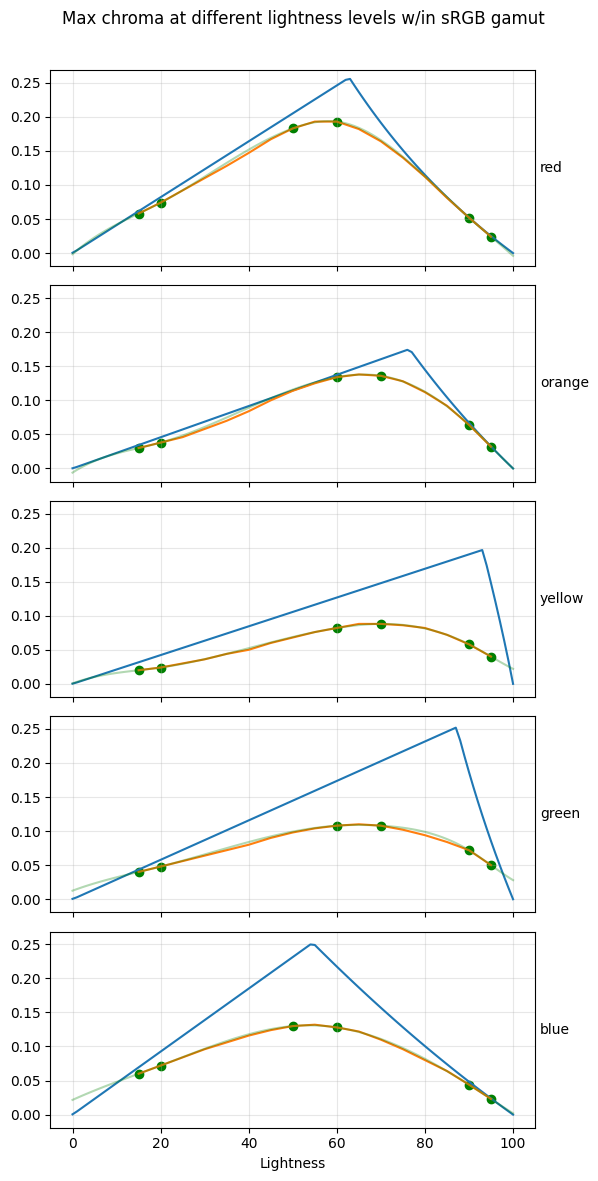

In [4]:
# max chroma bounds
hue_cmax_map = {}
for hue_key, hue_val in hue_map.items():
    hue_cmax_map[hue_key] = []
    for ll in lightness_levels_n1:
        max_chroma = max_chroma_fixed_LH(ll/100, hue_val)[0]
        hue_cmax_map[hue_key].append(max_chroma)

# interpolated chroma levels
hue_cinterp_lin_map = {}
hue_cinterp_cub_map = {}
for hue_key, hue_val in accent_hue_map.items():
    x1 = np.array(lightness_levels_n1)
    x5 = np.array(lightness_levels_n5)
    y5 = np.array(mb_chroma_pts[hue_key])

    y1 = np.interp(x1, x5, y5)
    hue_cinterp_lin_map[hue_key] = y1
    
    f = interp1d(x5, y5, kind='quadratic', fill_value='extrapolate')
    f = CubicSpline(x5, y5, bc_type='natural')
    hue_cinterp_cub_map[hue_key] = f(x1)

    # use just: start, end, and max
    max_idx = np.argmax(y5)
    f = CubicSpline(
        [x5[0], x5[1], x5[max_idx-1], x5[max_idx+1], x5[-2], x5[-1]],
        [y5[0], y5[1], y5[max_idx-1], y5[max_idx+1], y5[-2], y5[-1]],
        bc_type='natural'
    )
    hue_cinterp_cub_map[hue_key] = f(x1)

# stacked plots for accents
fig, axes = plt.subplots(len(accent_hue_map), 1, sharex=True, sharey=True, figsize=(6, 12))
for ax, hue_label in zip(axes, accent_hue_map):
    ax.plot(lightness_levels_n1, hue_cmax_map[hue_label])
    ax.plot(lightness_levels_n5, mb_chroma_pts[hue_label])
    
    #ax.plot(lightness_levels_n1, hue_cinterp_lin_map[hue_label])
    ax.plot(lightness_levels_n1, hue_cinterp_cub_map[hue_label], c='g', alpha=0.3)

    max_idx = np.argmax(mb_chroma_pts[hue_label])
    spline_indices = [0, 1, max_idx-1, max_idx+1, -2, -1]
    
    ax.scatter(
        np.array(lightness_levels_n5)[spline_indices],
        np.array(mb_chroma_pts[hue_label])[spline_indices],
        c='g'
    )
    
    ax.grid(True, alpha=0.3)
    ax.text(1.01, 0.5, hue_label, transform=ax.transAxes, va='center')
    
axes[-1].set_xlabel("Lightness")
plt.suptitle("Max chroma at different lightness levels w/in sRGB gamut")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

In [5]:
monotone_chroma = 0.011  # fixed monotone chroma
hl_hex_arr = []
hl_oklch_map = {}
hl_hex_map = {}

for i, (hue_name, hue) in enumerate(hue_map.items()):
    lo_map, lh_map = {}, {}
    hl_hex_arr.append(f"[{hue_name}]")
    chroma_n1 = hue_cinterp_cub_map.get(hue_name)
    for j, lightness in enumerate(lightness_levels_n1):
        if i == 0:
            chroma = 0
        elif i <= 5:
            chroma = monotone_chroma
        else:
            chroma = chroma_n1[j]
            
        c_oklch = Color('oklch', [lightness/100, chroma, hue])
        c_srgb = c_oklch.convert('srgb')
        
        oklch_str = c_oklch.to_string(percent=True)
        hex_str = c_srgb.to_string(hex=True)
        
        lo_map[f"l{lightness}"] = oklch_str
        lh_map[f"l{lightness}"] = hex_str
        hl_hex_arr.append(f'l{lightness} = "{hex_str}"')

    hl_oklch_map[hue_name] = lo_map
    hl_hex_map[hue_name] = lh_map
    hl_hex_arr.append("")

# write files
toml_hex = '\n'.join(hl_hex_arr)
with Path(PALETTE_DIR, 'monobiome-v111.toml').open('w') as f:
    f.write(toml_hex)
    
with Path(PALETTE_DIR, 'monobiome-v111-oklch.json').open('w') as f:
    json.dump(hl_oklch_map, f)

### Attempt to design unified chroma curve for all accents
After full exploration: nice to have this option, but unifying the chroma curve for all accents mutes their unique qualities. I think it's better to flesh out curves that fully leverage their chroma depths; can maybe standardize the start and end chromas but that's all. Perhaps there's some curve quality that can be applied broadly, but even that can be a bit rough.

#### Estimate intersection point

In [6]:
indices = [0, 1, -2, -1]
for hue in hue_cmax_map:
    print( np.array(np.array(hue_cmax_map[hue])[indices]) )
print()

# min values after checking 0, 1, -2, -1; then eyeballing l70 and l45
indices = [     0,      1,     30,     55,     -2,     -1]
values  = [0.0315, 0.0337, 0.0900, 0.1250, 0.0285, 0.0236]

# take a look at yellow & blue, the two bottom bounding lines
print( 'yellow', np.array(hue_cmax_map["yellow"])[50:60] )
print( 'blue', np.array(hue_cmax_map["blue"])[50:60] )
# so near guess at that max point is (71, 0.15); see the intersection
# point below. This is eyeballed to see where Y & B values cross

[0.00098114 0.0040535  0.00518646 0.        ]
[0.00050583 0.00410004 0.00483475 0.        ]
[0.00029984 0.00229111 0.00628815 0.        ]
[0.00028915 0.00211182 0.03240891 0.        ]
[0.00058517 0.00289383 0.01599808 0.        ]
[0.0004776  0.0046257  0.00466537 0.        ]
[0.00050583 0.00410004 0.00483475 0.        ]
[0.00029984 0.00229111 0.00628815 0.        ]
[0.00028915 0.00211182 0.03240891 0.        ]
[0.00058517 0.00289383 0.01599808 0.        ]
[0.0004776  0.0046257  0.00466537 0.        ]

yellow [0.10558548 0.1076973  0.10980911 0.11192093 0.11403275 0.1161438
 0.11825562 0.12036743 0.12247925 0.12459106]
blue [0.23125534 0.23588028 0.24050522 0.24513092 0.24975586 0.24896698
 0.24254303 0.23615799 0.22981262 0.22350693]


#### Verify best "pushed up" unified chroma curve

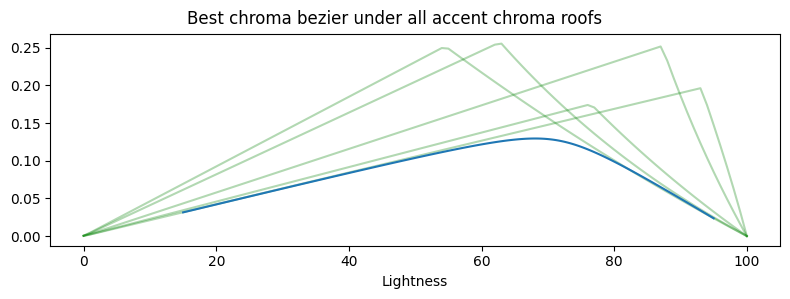

In [7]:
# get the 3 points to shape the bezier
indices = [    15,     71,     95]
values  = [0.0315, 0.1500, 0.0236]

P0 = np.array([indices[0], values[0]])
P1 = np.array([indices[1], values[1]])
P2 = np.array([indices[2], values[2]])

t = np.linspace(0, 1, len(lightness_levels_n1)+1)[:, None]
B = quad_bezier_rational(P0, P1, P2, w=5.0, t=t)

fig, ax = plt.subplots(figsize=(8, 3))
for hue_label in accent_hue_map:
    ax.plot(lightness_levels_n1, hue_cmax_map[hue_label], c='g', alpha=0.3)

# B is 2D, curve is parametrized; first dim are transformed `t` points
ax.plot(B[:,:,0], B[:,:,1]) 

ax.set_xlabel("Lightness")
plt.suptitle("Best chroma bezier under all accent chroma roofs")
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.show()

#### Put together unified chroma & generate color strings

In [8]:
# calculate curve at exact lightness; counter the bezier reparameterization
shared_max_chroma_n1 = bezier_y_at_x(P0, P1, P2, 5.0, lightness_levels_n1)

monotone_chroma = 0.011  # fixed monotone chroma
hl_hex_arr = []
hl_oklch_map = {}
hl_hex_map = {}

for i, (hue_name, hue) in enumerate(hue_map.items()):
    lo_map, lh_map = {}, {}
    hl_hex_arr.append(f"[{hue_name}]")
    for j, lightness in enumerate(lightness_levels_n1):
        if i == 0:
            chroma = 0
        elif i <= 5:
            chroma = monotone_chroma
        else:
            chroma = shared_max_chroma_n1[j]
            
        c_oklch = Color('oklch', [lightness/100, chroma, hue])
        c_srgb = c_oklch.convert('srgb')
        
        # oklch_str = c_oklch.to_string(percent=True)
        l, c, h = c_oklch.convert('oklch').coords()
        oklch_str = f"oklch({l*100:.1f}% {c:.4f} {h:.1f})"
        
        hex_str = c_srgb.to_string(hex=True)
        
        lo_map[f"l{lightness}"] = oklch_str
        lh_map[f"l{lightness}"] = hex_str
        hl_hex_arr.append(f'l{lightness} = "{hex_str}"')

    hl_oklch_map[hue_name] = lo_map
    hl_hex_map[hue_name] = lh_map
    hl_hex_arr.append("")

# write files -- UCC = "unified chroma curve"
toml_hex = '\n'.join(hl_hex_arr)
with Path(PALETTE_DIR, 'monobiome-vUCC.toml').open('w') as f:
    f.write(toml_hex)
    
with Path(PALETTE_DIR, 'monobiome-vUCC-oklch.json').open('w') as f:
    json.dump(hl_oklch_map, f)

### Tailored chroma curves

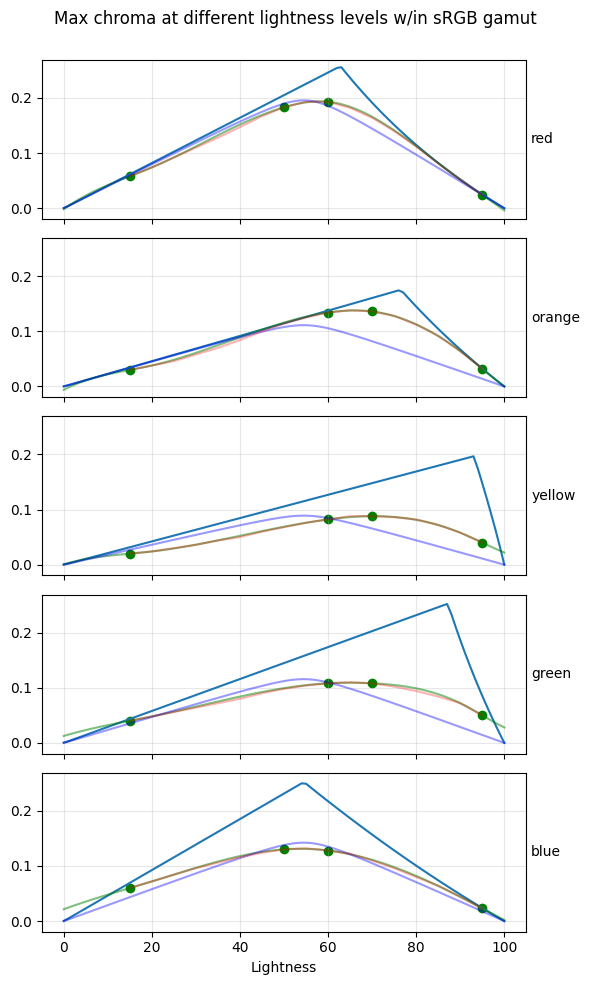

In [75]:
# indices = [    15,     95]
# values  = [0.0315, 0.0236]
indices = [0, 100]
values  = [0, 0]

# not the same chroma value, but sync *when* the max chroma is hit
# so similar curves but allowed to shift up and down
unified_cx = 55
unified_cy = [0.22, 0.125, 0.1, 0.13, 0.16]

hue_cinterp_cub_map_unify = {}
hue_cinterp_cub_map_unify_B = {}
for i, (hue_key, hue_val) in enumerate(accent_hue_map.items()):
    x1 = np.array(lightness_levels_n1)
    x5 = np.array(lightness_levels_n5)
    y5 = np.array(mb_chroma_pts[hue_key])

    max_idx = np.argmax(y5)
    # 2-point middle
    # f = CubicSpline(
    #     [indices[0], x5[max_idx-1], x5[max_idx+1], indices[-1]],
    #     [values[0],  y5[max_idx-1], y5[max_idx+1], values[-1]],
    #     bc_type='natural'
    # )
    # 1-point middle
    # f = CubicSpline(
    #     [indices[0], x5[max_idx], indices[-1]],
    #     [values[0],  y5[max_idx], values[-1]],
    #     bc_type='natural'
    # )
    f = CubicSpline(
        [indices[0], unified_cx, indices[-1]],
        [values[0],  unified_cy[i], values[-1]],
        bc_type='natural'
    )
    # hue_cinterp_cub_map_unify[hue_key] = f(x1)
    
    P0 = np.array([indices[0], values[0]])
    # P1 = np.array([x5[max_idx], y5[max_idx]])
    P1 = np.array([unified_cx, unified_cy[i]])
    P2 = np.array([indices[-1], values[-1]])
    
    t = np.linspace(0, 1, 400)[:, None]
    B = quad_bezier_rational(P0, P1, P2, w=8.0, t=t)
    hue_cinterp_cub_map_unify[hue_key] = B[:,:,1].flatten()
    hue_cinterp_cub_map_unify_B[hue_key] = B

fig, axes = plt.subplots(len(hue_cmax_map), 1, sharex=True, sharey=True, figsize=(6, 10))
for ax, hue_key in zip(axes, accent_hue_map):
    ax.grid(True, alpha=0.3)
    ax.text(1.01, 0.5, hue_key, transform=ax.transAxes, va='center')
    
    ax.plot(lightness_levels_n1, hue_cmax_map[hue_key])
    ax.plot(lightness_levels_n1, hue_cinterp_cub_map[hue_key], c='g', alpha=0.5)
    # ax.plot(lightness_levels_n1, hue_cinterp_cub_map_unify[hue_key], c='b', alpha=0.4)
    ax.plot(hue_cinterp_cub_map_unify_B[hue_key][:,:,0], hue_cinterp_cub_map_unify_B[hue_key][:,:,1], c='b', alpha=0.4)
    ax.plot(lightness_levels_n5, mb_chroma_pts[hue_key], c='r', alpha=0.3)

    max_idx = np.argmax(mb_chroma_pts[hue_key])
    spline_indices = [0, max_idx-1, max_idx+1, -1]
    
    ax.scatter(
        np.array(lightness_levels_n5)[spline_indices],
        np.array(mb_chroma_pts[hue_key])[spline_indices],
        c='g'
    )
    
axes[-1].set_xlabel("Lightness")
plt.suptitle("Max chroma at different lightness levels w/in sRGB gamut")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

In [10]:
indices = [    15,     95]
values  = [0.0315, 0.0236]

# not the same chroma value, but sync *when* the max chroma is hit
# so similar curves but allowed to shift up and down across hue
unified_cx = 55
unified_cy = [0.21, 0.13, 0.09, 0.13, 0.15]  # these were manually adjusted
hue_max_chroma_n1_map = {}
for i, (hue_key, hue_val) in enumerate(accent_hue_map.items()):
    P0 = np.array([indices[0], values[0]])
    # P1 = np.array([x5[max_idx], y5[max_idx]])
    P1 = np.array([unified_cx, unified_cy[i]])
    P2 = np.array([indices[-1], values[-1]])
    
    t = np.linspace(0, 1, 400)[:, None]
    hue_max_chroma_n1_map[hue_key] = bezier_y_at_x(P0, P1, P2, 5.0, lightness_levels_n1)
    
monotone_chroma = 0.011  # fixed monotone chroma
hl_hex_arr = []
hl_oklch_map = {}
hl_hex_map = {}

for i, (hue_name, hue) in enumerate(hue_map.items()):
    lo_map, lh_map = {}, {}
    hl_hex_arr.append(f"[{hue_name}]")
    max_chroma_n1 = hue_max_chroma_n1_map.get(hue_name)
    for j, lightness in enumerate(lightness_levels_n1):
        if i == 0:
            chroma = 0
        elif i <= 5:
            chroma = monotone_chroma
        else:
            chroma = max_chroma_n1[j]
            
        c_oklch = Color('oklch', [lightness/100, chroma, hue])
        c_srgb = c_oklch.convert('srgb')
        
        oklch_str = c_oklch.to_string(percent=True)
        hex_str = c_srgb.to_string(hex=True)
        
        lo_map[f"l{lightness}"] = oklch_str
        lh_map[f"l{lightness}"] = hex_str
        hl_hex_arr.append(f'l{lightness} = "{hex_str}"')

    hl_oklch_map[hue_name] = lo_map
    hl_hex_map[hue_name] = lh_map
    hl_hex_arr.append("")

# write files -- MCL = "max chroma lightness"
toml_hex = '\n'.join(hl_hex_arr)
with Path(PALETTE_DIR, 'monobiome-vMCL.toml').open('w') as f:
    f.write(toml_hex)
    
with Path(PALETTE_DIR, 'monobiome-vMCL-oklch.json').open('w') as f:
    json.dump(hl_oklch_map, f)

#### Verify the written colors

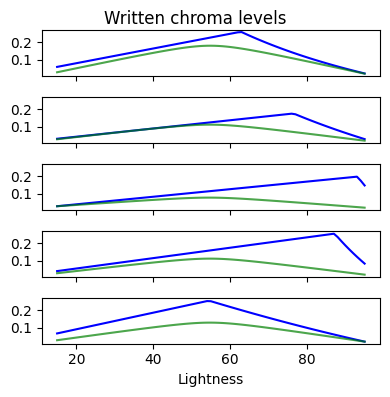

In [11]:
fig, axes = plt.subplots(len(hue_cmax_map), 1, sharex=True, sharey=True, figsize=(4, 4))
for ax, hue_label in zip(axes, accent_hue_map):
    chroma_list = [
        Color(oklch_str)._coords[1]
        for l_str, oklch_str in hl_oklch_map[hue_label].items()
    ]
    
    ax.plot(lightness_levels_n1, hue_cmax_map[hue_label], c='b')
    ax.plot(lightness_levels_n1, chroma_list, c='g', alpha=0.7)
    
axes[-1].set_xlabel("Lightness")
plt.suptitle("Written chroma levels")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

In [12]:
# preview palette

# fig, axes = plt.subplots(len(hue_cmax_map), 1, sharex=True, sharey=True, figsize=(4, 4))
# for ax, hue_label in zip(axes, accent_hue_map):
#     for l_str, oklch_str in hl_oklch_map[hue_label].items():
#         Color(oklch_str)

#### 3-point quadratic bezier fit to v1.1.1
The more "systematic" design choices for picking chroma curves seem to stamp on accent identifies, even the fixed lightness point (but allowing variable chroma).

Linear or cubic interpolation of the original 5% lightness jumps is acceptable, but I want two things in the new rev:

1. Fixed chroma settings at the beginning (15) and end (95) lightness settings for each accent. This at least gives us some unified bounds for filling in the chroma curve, even if the shapes and control points of the curves vary quite a bit to make the color identities fit as intended.
2. Follow a parameterized curve rather than being ad hoc, discrete jumps. The previously chosen chroma changes across 5% lightness jumps were something close to linear interpolation between established control points, but they were not reporoducible. That is, it was based on some loose napkin math rather than an established mathematical relatinship that could be written down. Even if I imitate the original curves as closely as possible, I want a parameterized model for the curve to ulimately produce it.

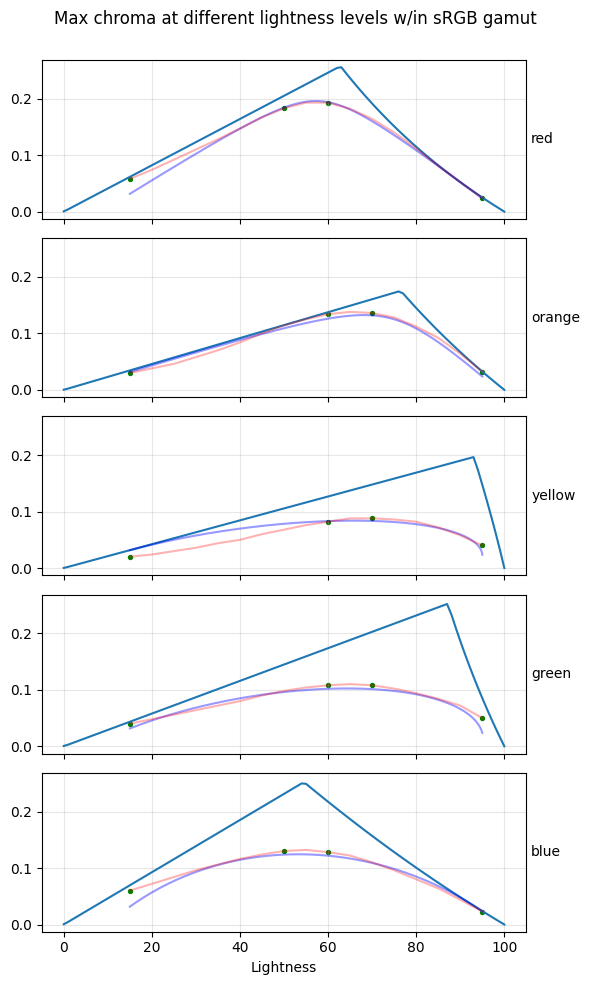

In [78]:
# archiving these weights and offsets: specific to the 15 and 95 endpoints
indices = [    15,     95]
values  = [0.0315, 0.0236]

accent_weights = {
    "red": 4.0,
    "orange": 3.0,
    "yellow": 0.5,
    "green": 0.5,
    "blue": 0.8,
}
accent_offsets = {
    "red": -5,
    "orange": -3,
    "yellow": 0,
    "green": 0,
    "blue": -1,
}
hue_bez_cmax_map = {}
for i, (hue_key, hue_val) in enumerate(accent_hue_map.items()):
    cmax_idx = np.argmax(hue_cmax_map[hue_key])
    cmax_idx += accent_offsets[hue_key]

    cmax_lightness = lightness_levels_n1[cmax_idx]
    cmax_chroma = hue_cmax_map[hue_key][cmax_idx]

    P0 = np.array([indices[0], values[0]])
    P1 = np.array([cmax_lightness, cmax_chroma])
    P2 = np.array([indices[-1], values[-1]])
    
    t = np.linspace(0, 1, 400)[:, None]
    B = quad_bezier_rational(P0, P1, P2, w=accent_weights[hue_key], t=t)
    
    hue_bez_cmax_map[hue_key] = B

fig, axes = plt.subplots(len(hue_cmax_map), 1, sharex=True, sharey=True, figsize=(6, 10))
for ax, hue_key in zip(axes, accent_hue_map):
    ax.grid(True, alpha=0.3)
    ax.text(1.01, 0.5, hue_key, transform=ax.transAxes, va='center')
    
    ax.plot(lightness_levels_n1, hue_cmax_map[hue_key])
    ax.plot(hue_bez_cmax_map[hue_key][:,:,0], hue_bez_cmax_map[hue_key][:,:,1], c='b', alpha=0.4)
    ax.plot(lightness_levels_n5, mb_chroma_pts[hue_key], c='r', alpha=0.3)

    max_idx = np.argmax(mb_chroma_pts[hue_key])
    spline_indices = [0, max_idx-1, max_idx+1, -1]
    
    ax.scatter(
        np.array(lightness_levels_n5)[spline_indices],
        np.array(mb_chroma_pts[hue_key])[spline_indices],
        s=8, c='g'
    )
    
axes[-1].set_xlabel("Lightness")
plt.suptitle("Max chroma at different lightness levels w/in sRGB gamut")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

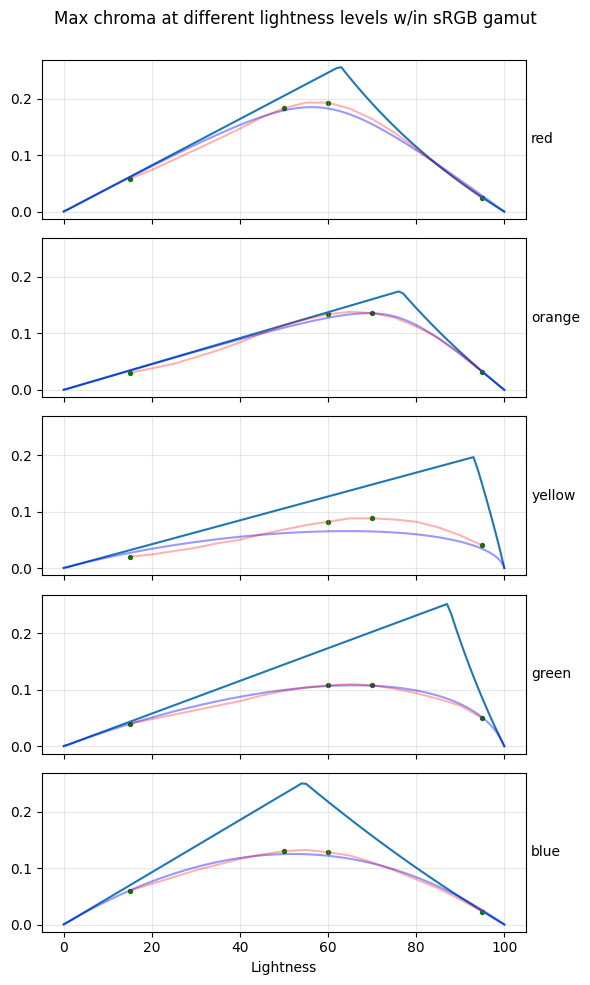

In [138]:
indices = [0, 100]
values  = [0, 0]

accent_weights = {
    "red": 3.5,
    "orange": 4.0,
    "yellow": 0.5,
    "green": 0.75,
    "blue": 1.0,
}
accent_offsets = {
    "red": -5,
    "orange": -2,
    "yellow": 0,
    "green": 0,
    "blue": 0,
}
hue_bez_cmax_map = {}
for i, (hue_key, hue_val) in enumerate(accent_hue_map.items()):
    cmax_idx = np.argmax(hue_cmax_map[hue_key])
    cmax_idx += accent_offsets[hue_key]

    cmax_lightness = lightness_levels_n1[cmax_idx]
    cmax_chroma = hue_cmax_map[hue_key][cmax_idx]

    P0 = np.array([indices[0], values[0]])
    P1 = np.array([cmax_lightness, cmax_chroma])
    P2 = np.array([indices[-1], values[-1]])
    
    t = np.linspace(0, 1, 400)[:, None]
    B = quad_bezier_rational(P0, P1, P2, w=accent_weights[hue_key], t=t)
    
    hue_bez_cmax_map[hue_key] = B

fig, axes = plt.subplots(len(accent_hue_map), 1, sharex=True, sharey=True, figsize=(6, 10))
for ax, hue_key in zip(axes, accent_hue_map):
    ax.grid(True, alpha=0.3)
    ax.text(1.01, 0.5, hue_key, transform=ax.transAxes, va='center')
    
    ax.plot(lightness_levels_n1, hue_cmax_map[hue_key])
    ax.plot(hue_bez_cmax_map[hue_key][:,:,0], hue_bez_cmax_map[hue_key][:,:,1], c='b', alpha=0.4)
    ax.plot(lightness_levels_n5, mb_chroma_pts[hue_key], c='r', alpha=0.3)

    max_idx = np.argmax(mb_chroma_pts[hue_key])
    spline_indices = [0, max_idx-1, max_idx+1, -1]
    
    ax.scatter(
        np.array(lightness_levels_n5)[spline_indices],
        np.array(mb_chroma_pts[hue_key])[spline_indices],
        s=8, c='g'
    )
    
axes[-1].set_xlabel("Lightness")
plt.suptitle("Max chroma at different lightness levels w/in sRGB gamut")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()

In [125]:
hue_bez_cmax_map = {}
for i, (hue_key, hue_val) in enumerate(accent_hue_map.items()):
    cmax_idx = np.argmax(hue_cmax_map[hue_key])
    cmax_idx += accent_offsets[hue_key]

    cmax_lightness = lightness_levels_n1[cmax_idx]
    cmax_chroma = hue_cmax_map[hue_key][cmax_idx]

    P0 = np.array([indices[0], values[0]])
    P1 = np.array([cmax_lightness, cmax_chroma])
    P2 = np.array([indices[-1], values[-1]])
    
    hue_bez_cmax_map[hue_key] = bezier_y_at_x(
        P0, P1, P2, accent_weights[hue_key], lightness_levels_n1
    )
    
monotone_chroma = 0.011  # fixed monotone chroma
hl_hex_arr = []
hl_oklch_map = {}
hl_hex_map = {}

# filter lightnesses outside bounds
# l_points = list(range(10, 98+1))  # full 10-98
l_points = list(range(10, 95+1, 5))+[98]  # full 10-98

for i, (hue_name, hue) in enumerate(hue_map.items()):
    lo_map, lh_map = {}, {}
    hl_hex_arr.append(f"[{hue_name}]")
    
    chroma_n1 = hue_bez_cmax_map.get(hue_name)
    max_chroma_n1 = hue_cmax_map.get(hue_name)
    for j, lightness in enumerate(lightness_levels_n1):
        if i == 0:
            chroma = 0
        elif i <= 5:
            if monotone_chroma <= max_chroma_n1[j]:
                chroma = monotone_chroma
            else:
                print(f"'{hue_name}' breached max chroma at L{lightness}")
                chroma = max_chroma_n1[j]
        else:
            if chroma_n1[j] <= max_chroma_n1[j]:
                chroma = chroma_n1[j]
            else:
                print(f"'{hue_name}' breached max chroma at L{lightness}")
                chroma = max_chroma_n1[j]

        # filter lightness after change to print
        if lightness < l_bounds[0] or lightness > l_bounds[1]:
            continue
            
        c_oklch = Color('oklch', [lightness/100, chroma, hue])
        c_srgb = c_oklch.convert('srgb')
        
        oklch_str = c_oklch.to_string(percent=True)
        hex_str = c_srgb.to_string(hex=True)
        
        lo_map[f"l{lightness}"] = oklch_str
        lh_map[f"l{lightness}"] = hex_str
        hl_hex_arr.append(f'l{lightness} = "{hex_str}"')

    hl_oklch_map[hue_name] = lo_map
    hl_hex_map[hue_name] = lh_map
    hl_hex_arr.append("")

# write files -- QBR = "quadratic bezier rational"
toml_hex = '\n'.join(hl_hex_arr)
with Path(PALETTE_DIR, 'monobiome-vQBR.toml').open('w') as f:
    f.write(toml_hex)
    
with Path(PALETTE_DIR, 'monobiome-vQBR-oklch.json').open('w') as f:
    json.dump(hl_oklch_map, f)

'badlands' breached max chroma at L0
'badlands' breached max chroma at L1
'badlands' breached max chroma at L2
'badlands' breached max chroma at L98
'badlands' breached max chroma at L99
'badlands' breached max chroma at L100
'chaparral' breached max chroma at L0
'chaparral' breached max chroma at L1
'chaparral' breached max chroma at L2
'chaparral' breached max chroma at L3
'chaparral' breached max chroma at L4
'chaparral' breached max chroma at L99
'chaparral' breached max chroma at L100
'savanna' breached max chroma at L0
'savanna' breached max chroma at L1
'savanna' breached max chroma at L2
'savanna' breached max chroma at L3
'savanna' breached max chroma at L4
'savanna' breached max chroma at L5
'savanna' breached max chroma at L100
'grassland' breached max chroma at L0
'grassland' breached max chroma at L1
'grassland' breached max chroma at L2
'grassland' breached max chroma at L3
'grassland' breached max chroma at L100
'tundra' breached max chroma at L0
'tundra' breached max ch

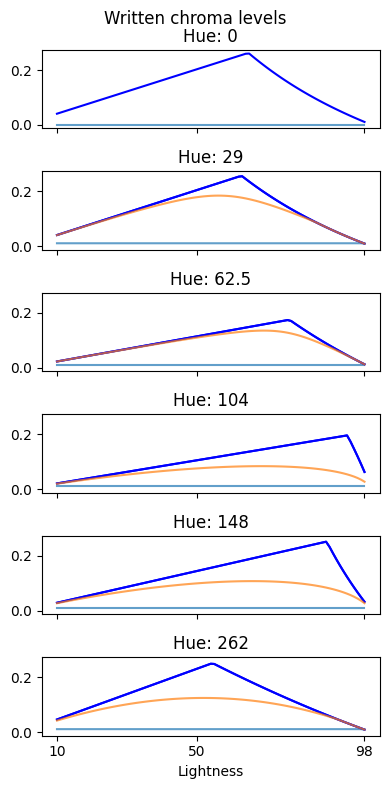

In [139]:
fig, axes = plt.subplots(len(monotone_hue_map), 1, sharex=True, sharey=True, figsize=(4, 8))
c, c_ax = 0, {}
for i, hue_label in enumerate(hue_map):
    hue_val = hue_map[hue_label]
    chroma_list = [
        Color(oklch_str)._coords[1]
        for l_str, oklch_str in hl_oklch_map[hue_label].items()
    ]

    if hue_val not in c_ax:
        c_ax[hue_val] = axes[i]
    ax = c_ax[hue_val]

    ax.title.set_text(f"Hue: {hue_val}")
    xs = np.array(lightness_levels_n1)[l_bounds[0]:l_bounds[1]+1]
    cs = np.array(hue_cmax_map[hue_label])[l_bounds[0]:l_bounds[1]+1]
    ax.plot(xs, cs, c='b')
    ax.plot(xs, chroma_list, alpha=0.7)
    
axes[-1].set_xlabel("Lightness")
ax.set_xticks([l_bounds[0], 50, l_bounds[1]])
plt.suptitle("Written chroma levels")
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show()